# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [1]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [2]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [3]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier01.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [4]:
df_Wine.shape

(3301, 25)

In [5]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [6]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [7]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [8]:
df_GeoCache.shape

(1224, 8)

In [9]:
df_Flag.shape

(19, 3)

In [10]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
1392,2007,93,2005,90.0,16,Domaine Sigalas,Asirtiko-Athiri Santorini,White,Assyrtiko,NaN,...,2007.0,NaN,"A very lush and complex white, with mouthfilli...",Hierarchy_01,"Aegean Islands, Greece","Aegean, Σάμη - Αγία Ευφημία, Καραβόμυλος, Δήμο...","(38.2504094, 20.6304217, 0.0)",38.250409,20.630422,0.0
133,2019,34,2015,93.0,23,Godelia,Mencía Bierzo,Red,Mencia,NaN,...,2019.0,2025.0,"Black cherry, plum and currant flavors give th...",Hierarchy_01,"Castilla y León, Spain","Castilla y León, España","(41.8037172, -4.7471726, 0.0)",41.803717,-4.747173,0.0
1066,2010,67,2007,92.0,28,Domaine Les Pallières,Gigondas Terrasse du Diable,Red,Blend,"Grenache, Mourvèdre and Clairette",...,2010.0,2015.0,"Polished and pure, with delicious layers of pl...",Hierarchy_01,"Rhône, France","Rhône, Circonscription départementale du Rhône...","(45.8802348, 4.564533629559522, 0.0)",45.880235,4.564534,0.0
3214,1988,15,1985,95.0,35,Ridge,Cabernet Sauvignon Santa Cruz Mountains Monte ...,Red,Cabernet Sauvignon,NaN,...,1988.0,2000.0,"Rich, tannic, intense and young, but it's pack...",Hierarchy_01,"California Central Coast, USA","Oakland Museum of California, 1000, Oak Street...","(37.7986189, -122.26354180946112, 0.0)",37.798619,-122.263542,0.0
873,2012,74,2007,93.0,38,Iron Horse,Brut Green Valley of Russian River Valley Clas...,Sparkling,Blend,Champagne Blend,...,2012.0,2016.0,"Seamless from start to finish, both rich and e...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
1864,2002,65,1999,92.0,30,S. Anderson,Cabernet Sauvignon Stags Leap District,Red,Cabernet Sauvignon,NaN,...,2004.0,2012.0,"Dark, intense and concentrated, with a beefy, ...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
1823,2002,24,1997,95.0,65,Casanova di Neri,Brunello di Montalcino Tenuta Nuova,Red,Brunello di Montalcino,NaN,...,2004.0,NaN,Like finely meshed cashmere. Exotic aromas of ...,Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
739,2013,40,2010,92.0,24,Château de Haute-Serre,Malbec Cahors White Label,Red,Malbec,NaN,...,2013.0,2018.0,"This ripe and alluring red offers rich, meaty ...",Hierarchy_01,"South West France, France","France, Meillonnas, Bourg-en-Bresse, Ain, Auve...","(46.2331191, 5.3544518, 0.0)",46.233119,5.354452,0.0
1697,2004,98,2002,90.0,18,Argyle,Pinot Noir Willamette Valley,Red,Pinot Noir,NaN,...,2004.0,2008.0,"Smooth and round, seductively plush but not ov...",Hierarchy_01,"Oregon, USA","Oregon, United States","(43.9792797, -120.737257, 0.0)",43.979280,-120.737257,0.0
1252,2008,53,2005,90.0,18,François Pelissié,Cahors Croix du Mayne,Red,Malbec,NaN,...,2008.0,2013.0,"There's a rich, spicy aroma, and this is dripp...",Hierarchy_01,"South West France, France","France, Meillonnas, Bourg-en-Bresse, Ain, Auve...","(46.2331191, 5.3544518, 0.0)",46.233119,5.354452,0.0


## Vintage French Champagne Wines where Cases Made was Non-Zero

In [11]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [12]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [13]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [14]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [15]:
# Include only French Champagne

df_Wine_V = df_Wine[
    (df_Wine.Address.str.contains('France') == True) &
    (df_Wine.Grape_Blend.str.contains('Champagne') == True)
]

df_Wine_V.shape

(51, 25)

In [16]:
# Count of French Champagne by Review Year
df_AMR_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Review_Year'])['Score'].count()}).reset_index()
df_AMR_Count['Year_Type'] = 'Review'
df_AMR_Count = df_AMR_Count.rename(columns={"Review_Year": "Year"})
df_AMR_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Champagne-Ardenne, France",Champagne,1988,3,Review
1,"Champagne-Ardenne, France",Champagne,1989,1,Review
2,"Champagne-Ardenne, France",Champagne,1990,2,Review
3,"Champagne-Ardenne, France",Champagne,1992,2,Review
4,"Champagne-Ardenne, France",Champagne,1993,3,Review


In [17]:
# Count of French Champagne by Review Year
df_AMV_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Vintage'])['Score'].count()}).reset_index()
df_AMV_Count['Year_Type'] = 'Vintage'
df_AMV_Count = df_AMV_Count.rename(columns={"Vintage": "Year"})
df_AMV_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Champagne-Ardenne, France",Champagne,1982,4,Vintage
1,"Champagne-Ardenne, France",Champagne,1983,1,Vintage
2,"Champagne-Ardenne, France",Champagne,1985,3,Vintage
3,"Champagne-Ardenne, France",Champagne,1988,2,Vintage
4,"Champagne-Ardenne, France",Champagne,1989,2,Vintage


In [18]:
frames = [df_AMR_Count, df_AMV_Count]
df_AM_Count = pd.concat(frames)
df_AM_Count['Year'] = df_AM_Count.Year.astype(str)

In [19]:
# Score by Review Year

In [20]:
# Score by Vintage Year

### Visualization

In [21]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [22]:
# define a function to graph summary data

def summary_barplot(year_type):
    
    df = df_AM_Count[(df_AM_Count.Year_Type == year_type)]
    
    g = sns.barplot(
        data = df,
        x = 'Count',
        y = 'Year',
        orient = 'h',
        hue = 'Year_Type',
        ci = None
    )
    
    sns.mpl.rc("figure", figsize=(10, 15))
    
    plt.suptitle('Count of French Champagne Scores in Wine Spectator Top 100 Lists by ' + year_type)
    plt.savefig('./images/frenchchampagne_barplot_countscores_byyear.png')

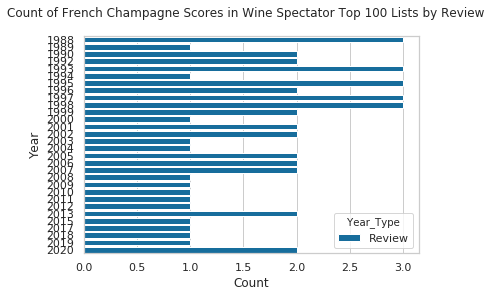

In [23]:
summary_barplot('Review')

### Analysis by Winemaker

In [24]:
# Count of French Champagne by Review Year by Winemaker
df_AMW_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Winemaker'])['Score'].count()}).reset_index()

# Count of French Champagne by Review Year
df_AMW_Price = pd.DataFrame({'Average_Price' : df_Wine_V.groupby(['Winemaker'])['Price'].mean()}).reset_index()

# Count of French Champagne by Review Year
df_AMW_Score = pd.DataFrame({'Average_Score' : df_Wine_V.groupby(['Winemaker'])['Score'].mean()}).reset_index()

frame = [df_AMW_Count, df_AMW_Price, df_AMW_Score]
df_AMW = pd.concat(frame, sort = True, axis = 1)
df_AMW = df_AMW.T.drop_duplicates().T

df_AMW

,Winemaker,Count,Average_Price,Average_Score
0,Ayala,1,40,92
1,Bollinger,6,65.8333,94.1667
2,Bérêche & Fils,1,46,92
3,Cattier,1,30,91
4,Charles Ellner,1,34,93
5,Charles Heidsieck,2,56.5,96
6,Chartogne-Taillet,1,50,92
7,Delamotte,1,50,95
8,Drappier,2,32.5,91
9,Duval-Leroy,3,34.3333,91.6667


In [25]:
# define a function to graph summary data

def winemaker():
    
    df = df_AMW
    
    # Make the pairgrid
    g = sns.PairGrid(df.sort_values(by = 'Average_Score', ascending = False),
                     x_vars = df.columns[1:4],
                     y_vars = df.columns[0],
                     height = 10,
                     aspect = 0.25
                    )
    
    # Draw dot plot using stripplot function
    g.map(sns.stripplot,
          size = 10, 
          orient = 'h',
          jitter = False,
          palette = 'colorblind',
          linewidth = 1,
          edgecolor = 'w')
    
    # Use semantically meaningful titles for the columns
    titles = ['Count', 'Average Price', 'Average Score']
    
    for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axis
        
        ax.set(title = title)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)

    sns.despine(left = True, bottom = True)
    
    plt.suptitle('French Champagne\nCount, Average Score, and Average Price in Wine Spectator Top 100 Lists\nReview Years 1988-2020', y = 1.1)
    plt.savefig('./images/frenchchampagne_dotplot_countscores_byyear.png')
    plt.savefig('./images/frenchchampagne_dotplot_countscores_byyear.jpg')

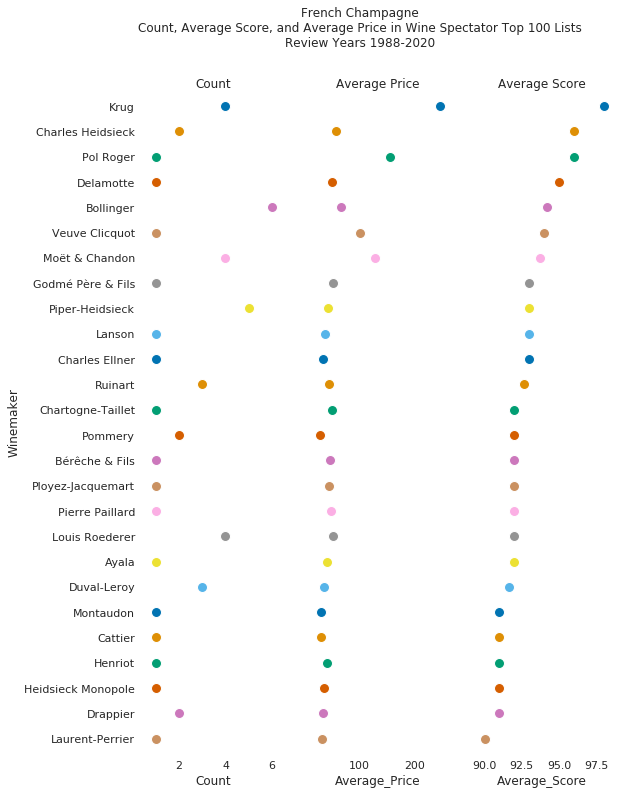

In [26]:
winemaker()